# Import thư viện

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tsai

In [ ]:
from tsai.all import *
from tsai.imports import *
from tsai.utils import *
from tsai.models.layers import *
from tsai.models.utils import *

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import math
from keras.models import Sequential
from keras.layers import Dense,LSTM
import os.path
from os import path
from pylab import rcParams
from random import randrange
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.tsatools import freq_to_period
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
import pickle
import os
import joblib

# Phân tích dữ liệu

In [ ]:
# Library to support working with data
import pandas as pd
import numpy as np

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Performance metrics calculation support library
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, mean_squared_log_error

# Graphing support library
from matplotlib import ticker
import matplotlib.pyplot as plt


df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Analysis/AZN-AstraZeneca.csv')
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

# Select the Close column as the dependent variable
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))
data_scaled = np.squeeze(data_scaled)

In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1.323000e+03
mean,57.810741,58.241572,57.361141,57.802268,54.645808,6.026589e+06
std,9.791558,9.834293,9.745705,9.791189,11.063517,4.664387e+06
min,36.810001,37.389999,36.150002,37.279999,32.892757,7.558000e+05
25%,50.520000,50.735000,50.005001,50.325001,46.172081,3.622000e+06
50%,57.599998,58.110001,57.130001,57.689999,54.302544,4.951600e+06
75%,66.200001,66.750000,65.720001,66.270001,64.117497,6.986300e+06
max,79.320000,79.360001,78.379997,79.180000,79.180000,6.554020e+07


In [ ]:
df['Close']

Date
2019-03-01    41.759998
2019-03-04    41.689999
2019-03-05    42.310001
2019-03-06    42.029999
2019-03-07    41.660000
                ...    
2024-05-24    78.540001
2024-05-28    76.620003
2024-05-29    76.080002
2024-05-30    76.769997
2024-05-31    78.019997
Name: Close, Length: 1323, dtype: float64

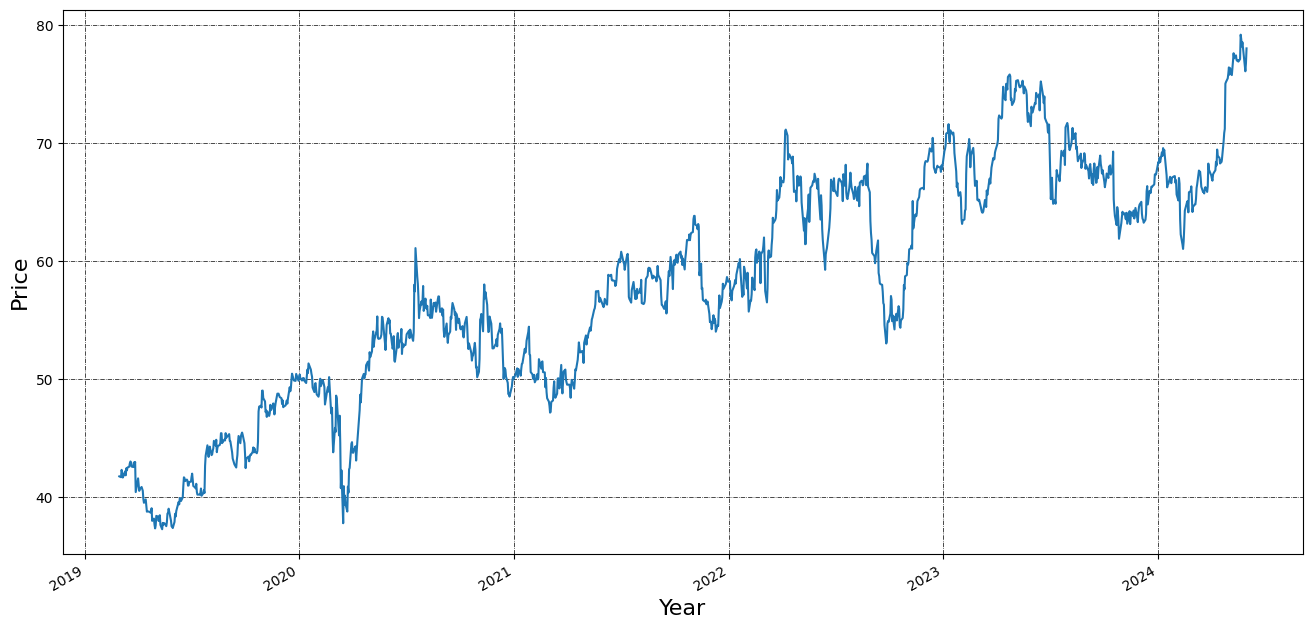

In [ ]:
import matplotlib.ticker as ticker

df['Close'].plot(figsize=(16, 8))

plt.ylabel('Price', fontsize=16)
plt.xlabel('Year', fontsize=16)

plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)

plt.show()

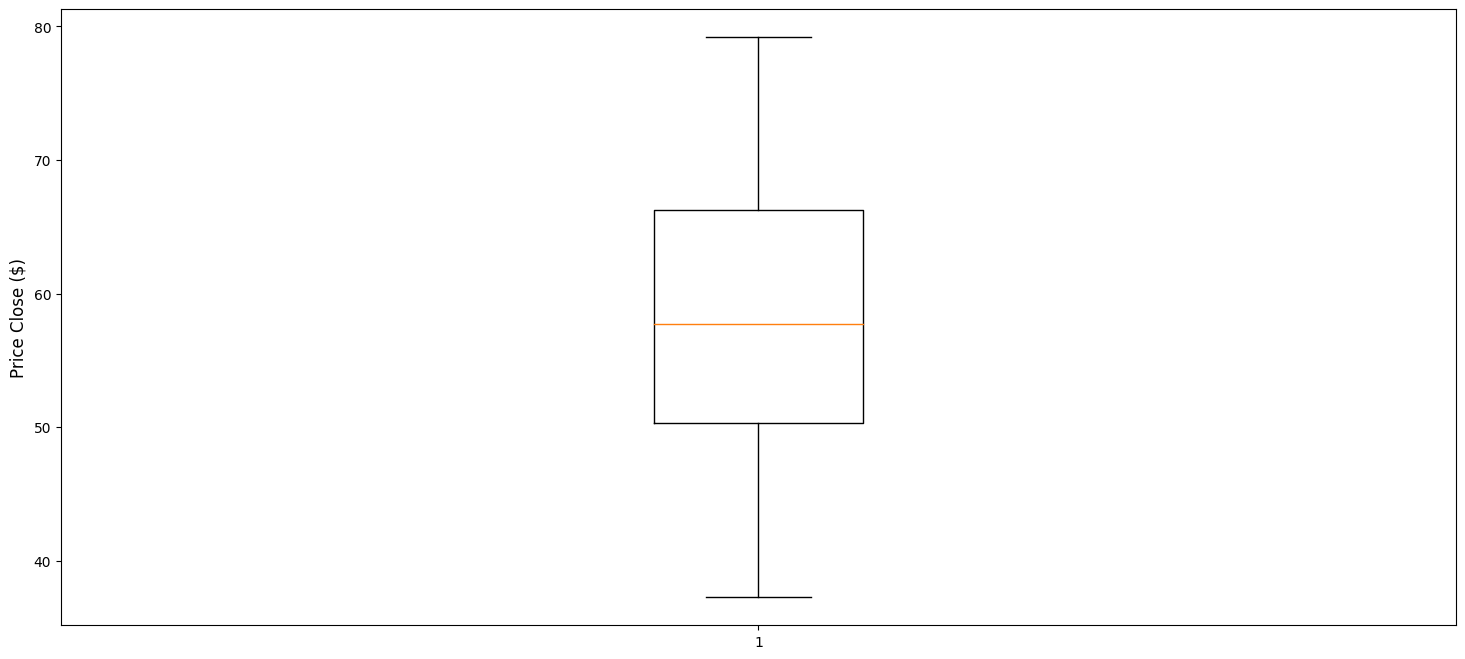

In [ ]:
plt.figure(figsize=(18, 8))
plt.boxplot(df['Close'])
plt.ylabel("Price Close ($)", fontsize=12)
plt.show()

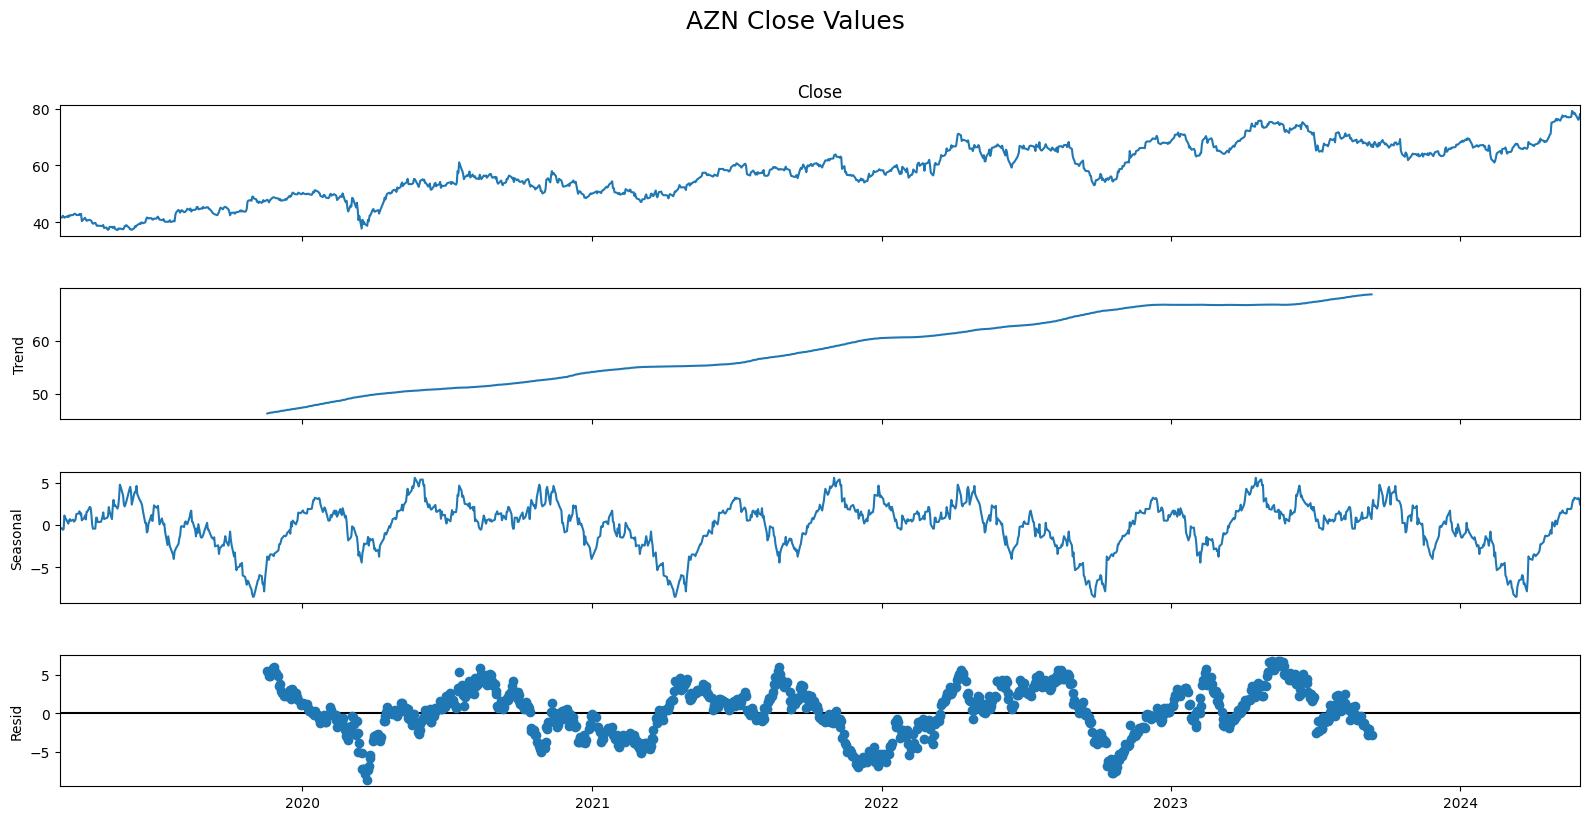

In [ ]:
rcParams['figure.figsize'] = 16,8
decomposition = seasonal_decompose(df['Close'], model = 'additive', period = 365)
fig = decomposition.plot()
# Đặt tiêu đề cho biểu đồ với khoảng cách y thích hợp
fig.suptitle('AZN Close Values', fontsize=18, y=1.02)

# Điều chỉnh khoảng cách giữa các phần của biểu đồ
plt.subplots_adjust(top=0.9, hspace=0.4)
plt.show()

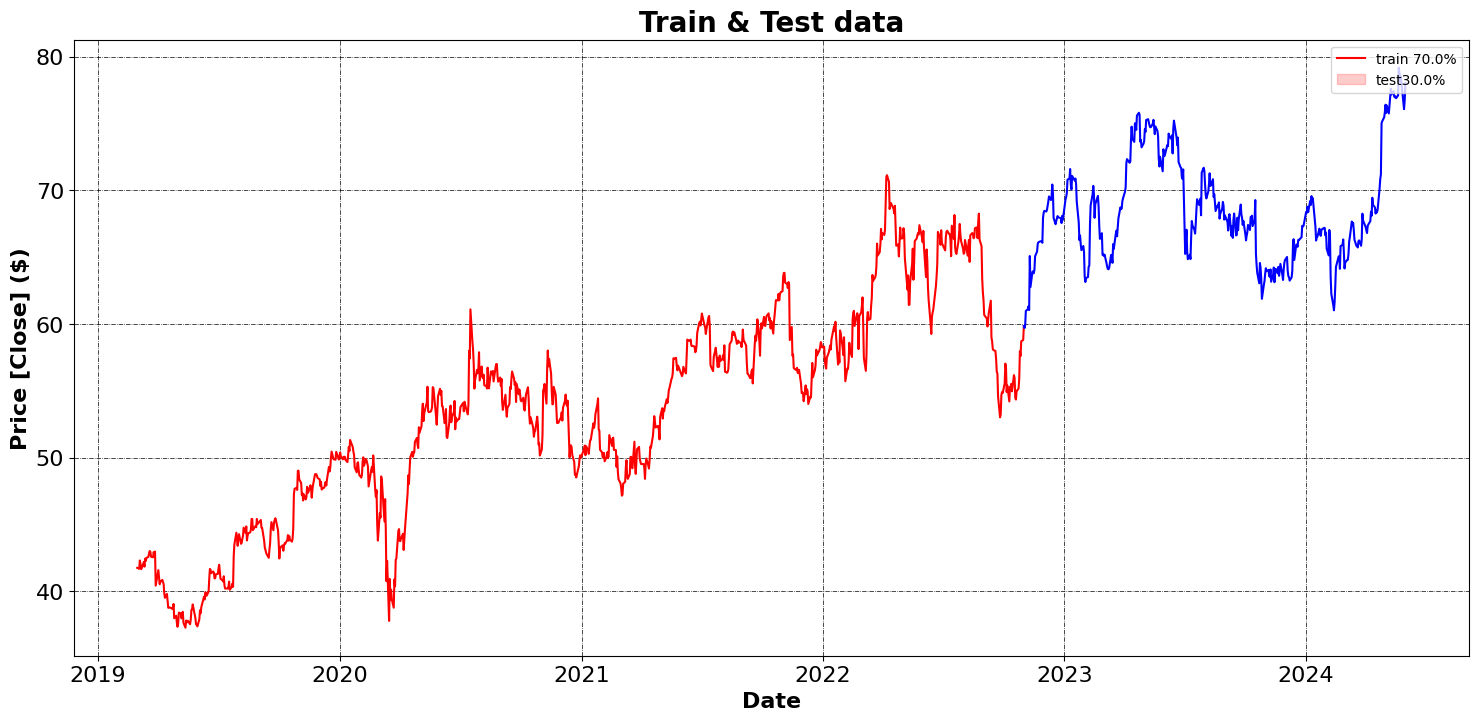

In [ ]:
size = 0.7  # Chia train test
size_train = int(len(df) * size)
fig, ax = plt.subplots(figsize=(18,8)) # 4.5, 2
sns.lineplot(x = df.index[:size_train+1], y = df['Close'][:size_train+1], color = 'red')
sns.lineplot(x = df.index[size_train:], y = df['Close'][size_train:], color = 'blue')

ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price [Close] ($)', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train ' + str(size*100) + '%', 'test'+ str(100 - size*100) + '%'))
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

In [ ]:
print("Tập train:")
print(df[:size_train]['Close'].describe())
print("")
print("Tập test:")
print(df[size_train:]['Close'].describe())

Tập train:
count    926.000000
mean      53.236782
std        7.787169
min       37.279999
25%       48.192499
50%       53.975001
75%       58.407500
max       71.139999
Name: Close, dtype: float64

Tập test:
count    397.000000
mean      68.451234
std        3.996035
min       59.700001
25%       65.730003
50%       67.820000
75%       70.489998
max       79.180000
Name: Close, dtype: float64


# Mô hình

In [ ]:
#|export
class _ResCNNBlock(Module):
    def __init__(self, ni, nf, kss=[7, 5, 3], coord=False, separable=False, zero_norm=False):
        self.convblock1 = ConvBlock(ni, nf, kss[0], coord=coord, separable=separable)
        self.convblock2 = ConvBlock(nf, nf, kss[1], coord=coord, separable=separable)
        self.convblock3 = ConvBlock(nf, nf, kss[2], act=None, coord=coord, separable=separable, zero_norm=zero_norm)

        # expand channels for the sum if necessary
        self.shortcut = ConvBN(ni, nf, 1, coord=coord)
        self.add = Add()
        self.act = nn.ReLU()

    def forward(self, x):
        res = x
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.add(x, self.shortcut(res))
        x = self.act(x)
        return x


class ResCNN(Module):
    def __init__(self, c_in, c_out, coord=False, separable=False, zero_norm=False):
        nf = 64
        self.block1 = _ResCNNBlock(c_in, nf, kss=[7, 5, 3], coord=coord, separable=separable, zero_norm=zero_norm)
        self.block2 = ConvBlock(nf, nf * 2, 3, coord=coord, separable=separable, act=nn.LeakyReLU, act_kwargs={'negative_slope':.2})
        self.block3 = ConvBlock(nf * 2, nf * 4, 3, coord=coord, separable=separable, act=nn.PReLU)
        self.block4 = ConvBlock(nf * 4, nf * 2, 3, coord=coord, separable=separable, act=nn.ELU, act_kwargs={'alpha':.3})
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.squeeze = Squeeze(-1)
        self.lin = nn.Linear(nf * 2, c_out)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.squeeze(self.gap(x))
        return self.lin(x)

class ResCNN_LSTM(Module):
    def __init__(self, c_in, c_out, hidden_dim, num_layers, coord=False, separable=False, zero_norm=False):
        super().__init__()
        self.ResCNN = ResCNN(c_in, hidden_dim, coord=coord, separable=separable, zero_norm=zero_norm)
        self.LSTM = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, c_out)

    def forward(self, x):
        x = self.ResCNN(x)
        x, _ = self.LSTM(x.unsqueeze(0))
        x = self.fc(x.squeeze(0))
        return x


In [ ]:
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

# Chia dữ liệu thành các cặp input-output
X = []
y = []
day_in = 50 # Số lượng input ngày khi đi vào model
day_out = 30 # Số lượng ngày dự đoán tiếp theo
# => ngày 1->50 dư đoán ngày 51->80
# => ngày 2->51 dư đoán ngày 52->81
# .....
for i in range(len(data_scaled) - (day_in + day_out)):
    X.append(data_scaled[i:i+day_in])
    y.append(data_scaled[i+day_in:i+day_out+ day_in])

# Chia dữ liệu thành tập train và test
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# Chuyển dữ liệu thành tensor và tạo DataLoader
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1), torch.tensor(y_train, dtype=torch.float32))
test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1), torch.tensor(y_test, dtype=torch.float32))
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

In [ ]:
# Khởi tạo model và optimizer
model = ResCNN_LSTM(day_in, day_out, 64, 2)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Huấn luyện model
num_epoch = 100
for epoch in range(num_epoch):
    print("epoch: " + str(epoch) + " ===================================================")
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = nn.MSELoss()(output, batch_y)
        loss.backward()
        # print(loss)
        optimizer.step()

epoch: 0 ===================================================
epoch: 1 ===================================================
epoch: 2 ===================================================
epoch: 3 ===================================================
epoch: 4 ===================================================
epoch: 5 ===================================================
epoch: 6 ===================================================
epoch: 7 ===================================================
epoch: 8 ===================================================
epoch: 9 ===================================================
epoch: 10 ===================================================
epoch: 11 ===================================================
epoch: 12 ===================================================
epoch: 13 ===================================================
epoch: 14 ===================================================
epoch: 15 ===================================================
epoch: 16 ========

In [ ]:
# Chọn một mẫu dữ liệu từ tập test
test_sample = data_scaled[-day_in:]

# Chuyển mẫu dữ liệu thành tensor và thêm một chiều batch
test_sample_tensor = torch.tensor(test_sample, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)

# Dự đoán với mô hình
model.eval()  # Chuyển mô hình sang chế độ đánh giá
with torch.no_grad():  # Tắt việc tính toán gradient
    predictions = model(test_sample_tensor)
    predictions = predictions.squeeze().numpy()
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

# In ra kết quả dự đoán
print(predictions)

[[65.362015]
 [64.86373 ]
 [64.92197 ]
 [65.03376 ]
 [64.73902 ]
 [65.137825]
 [65.20462 ]
 [64.753654]
 [65.371185]
 [65.122   ]
 [64.72782 ]
 [64.569824]
 [64.12074 ]
 [64.031265]
 [65.28509 ]
 [64.57374 ]
 [64.05255 ]
 [64.963394]
 [64.36993 ]
 [64.21526 ]
 [64.303566]
 [64.66113 ]
 [64.241516]
 [63.283833]
 [64.95069 ]
 [64.66056 ]
 [64.475395]
 [63.867786]
 [63.689487]
 [63.668118]]


In [ ]:
# DỰ ĐOÁN TRÊN TẬP TEST
pred_test = []
real_test = np.array(df_Close[train_size:]).flatten()
real_test = real_test[:len(real_test) - day_out - day_in]


for i in range(len(X_test)): # Duyệt toàn bộ input tập test

  test_sample = X_test[i] # [1,2,3... 50] # day_in = 50
  # Chuyển mẫu dữ liệu thành tensor và thêm một chiều batch
  test_sample_tensor = torch.tensor(test_sample, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
  # Dự đoán với mô hình
  model.eval()  # Chuyển mô hình sang chế độ đánh giá
  with torch.no_grad():  # Tắt việc tính toán gradient
    predictions = model(test_sample_tensor)
    predictions = scaler.inverse_transform(np.array([predictions]).reshape(-1, 1))
    # lấy ngày đầu tiên cho việc tính toán
    pred_test.append(predictions[0][0])

In [ ]:
# Import mean_squared_error from sklearn.metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

# Calculate the MSE
mse = mean_squared_error(pred_test, real_test)
rmse = sqrt(mse)
mae = mean_absolute_error(pred_test, real_test)
mape = mean_absolute_percentage_error(pred_test, real_test)
print("RMSE: " + str(rmse))
print("MAE: " + str(mae))
print("MAPE: " + str(mape))

RMSE: 6.3502046389040245
MAE: 5.218281613564008
MAPE: 0.0822875733653094


In [ ]:
train_30 = df_Close['Close']
train_30

0       41.759998
1       41.689999
2       42.310001
3       42.029999
4       41.660000
          ...    
1318    78.540001
1319    76.620003
1320    76.080002
1321    76.769997
1322    78.019997
Name: Close, Length: 1323, dtype: float64

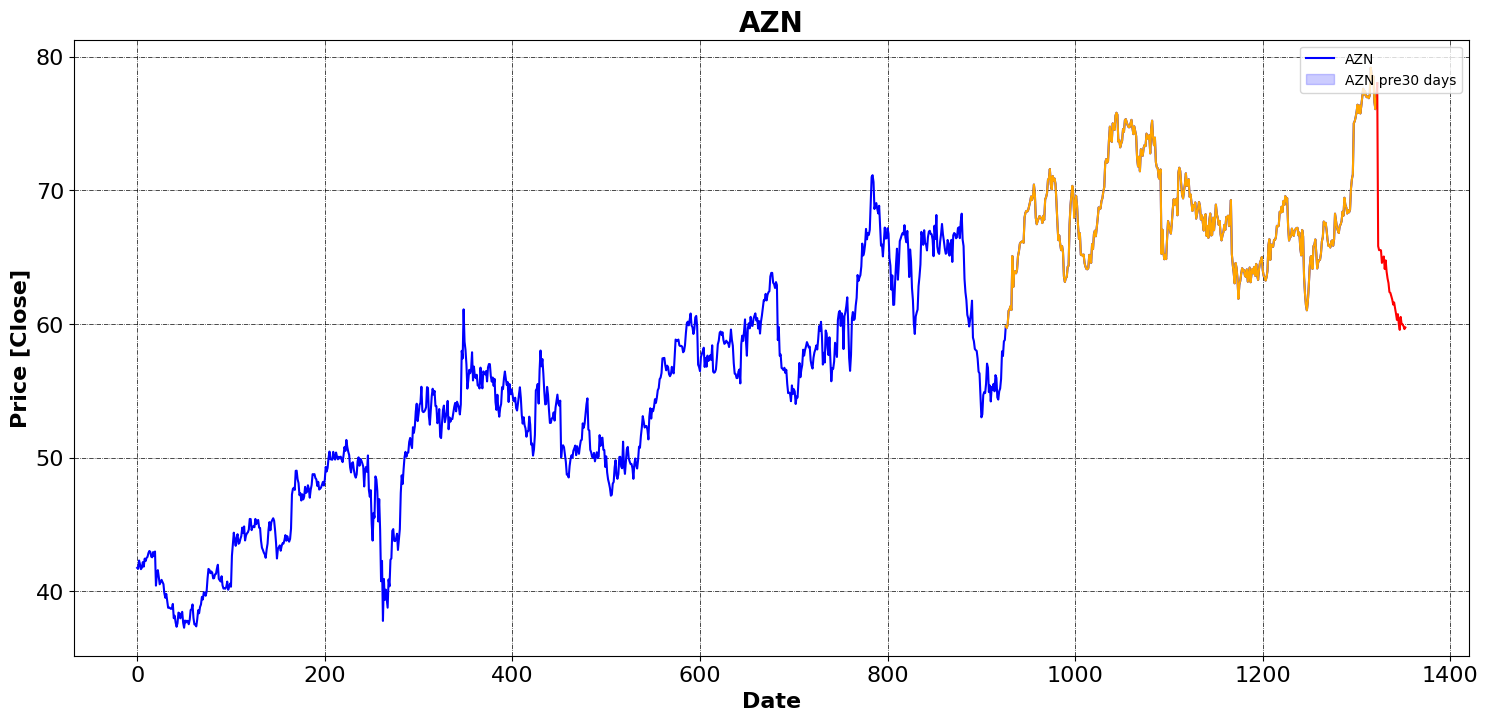

In [ ]:
train_30 = df_Close['Close']
series_data = pd.Series(predictions.squeeze())
new_start_index = train_30.index[-1] + 1
series_data.index = range(new_start_index, new_start_index + len(series_data))

# Nối hai series lại với nhau
train_30_pre = pd.concat([train_30, series_data])

fig, ax = plt.subplots(figsize=(18,8)) # 4.5, 2
sns.lineplot(x = df_Close.index[:], y = df_Close['Close'][:], color = 'blue')
sns.lineplot(x = df_Close.index[size_train:], y = df['Close'][size_train:], color = 'orange')
sns.lineplot(x = train_30_pre.index[-(day_out+1):], y = train_30_pre.values[-(day_out+1):], color = 'red')
# sns.lineplot(data = train_30_pre[-30:])
ax.set_title('AZN', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price [Close]', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('AZN', 'AZN pre' + str(day_out) + ' days'))
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Data Analysis/resCNN/Image/resCNN_73_30days_AZN.png')
plt.show()